<a href="https://colab.research.google.com/github/kompella-b/Intro2ML/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# Cell 1: Setup & datasets
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from math import sqrt
from IPython.display import display

# Use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Make data directory
os.makedirs("data", exist_ok=True)

# Download datasets (Brownlee's repo)
if not os.path.exists("data/airline-passengers.csv"):
    !wget -q -O data/airline-passengers.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

if not os.path.exists("data/daily-min-temperatures.csv"):
    !wget -q -O data/daily-min-temperatures.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv


def load_airline_passengers():
    """Monthly airline passengers dataset."""
    df = pd.read_csv("data/airline-passengers.csv")
    df["Month"] = pd.to_datetime(df["Month"])
    df.set_index("Month", inplace=True)
    y = df["Passengers"].astype(float)
    return y


def load_daily_min_temperatures():
    """Daily minimum temperatures in Melbourne."""
    df = pd.read_csv("data/daily-min-temperatures.csv")
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    y = df["Temp"].astype(float)
    return y


y_air = load_airline_passengers()
y_temp = load_daily_min_temperatures()

print("Airline series length:", len(y_air))
print("Temps series length  :", len(y_temp))
print(y_air.head())
print(y_temp.head())


Using device: cuda
Airline series length: 144
Temps series length  : 3650
Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: Passengers, dtype: float64
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64


In [ ]:
# ==========================================
# Cell 2: Metrics + calendar feature helpers
# ==========================================

def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return sqrt(np.mean((y_true - y_pred) ** 2))

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred) + eps)
    )

def mase(y_true, y_pred, insample, m=1, eps=1e-8):
    """
    MASE with seasonal naive scaling (period m).
    If there isn't enough insample data for seasonal scaling,
    it falls back to m=1 (non-seasonal naive).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    insample = np.asarray(insample)

    if len(insample) <= m:
        # Not enough data for seasonal naive -> fallback to naive
        m = 1

    scale = np.mean(np.abs(insample[m:] - insample[:-m]))
    if scale < eps:   # avoid division by zero
        return np.nan

    return np.mean(np.abs(y_true - y_pred)) / scale



# --- calendar features ---

def build_month_onehot_features(index):
    """
    For monthly data: one-hot month (12 dummies).
    """
    months = index.month - 1  # 0..11
    onehot = np.eye(12, dtype=np.float32)[months]
    return onehot  # [N, 12]

def build_dayofyear_sincos_features(index):
    """
    For daily data: sin/cos of day-of-year (2 features).
    Simpler than 365 dummies, still captures seasonality.
    """
    doy = index.dayofyear.values.astype(np.float32)
    radians = 2 * np.pi * doy / 365.0
    sin = np.sin(radians)
    cos = np.cos(radians)
    feats = np.stack([sin, cos], axis=1)
    return feats  # [N, 2]


In [ ]:
# ======================================
# Cell 3: Supervised windows + LSTM core
# ======================================

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def make_supervised_one_step_with_calendar(values_scaled, cal_feats, window):
    """
    Build a one-step-ahead supervised dataset.

    values_scaled : 1D array (scaled series)
    cal_feats     : None or array [N, C] of calendar features
    window        : length of input window

    Returns:
        X: [samples, window, input_dim]
        y: [samples, 1]
    """
    values_scaled = np.asarray(values_scaled, dtype=np.float32)
    N = len(values_scaled)
    if cal_feats is not None:
        cal_feats = np.asarray(cal_feats, dtype=np.float32)
        assert len(cal_feats) == N
        C = cal_feats.shape[1]
    else:
        cal_feats = None
        C = 0

    X_list, y_list = [], []
    for i in range(window, N):
        ys = values_scaled[i-window:i]         # [window]
        if cal_feats is not None:
            cs = cal_feats[i-window:i, :]      # [window, C]
            seq = np.concatenate([ys[:, None], cs], axis=1)  # [window, 1+C]
        else:
            seq = ys[:, None]                  # [window, 1]
        X_list.append(seq)
        y_list.append(values_scaled[i])        # next timestep

    if not X_list:
        raise ValueError("Not enough data for given window length.")

    X = np.stack(X_list, axis=0)               # [samples, window, input_dim]
    y = np.array(y_list, dtype=np.float32)[:, None]  # [samples, 1]
    return X, y


class LSTMForecaster(nn.Module):
    """
    Tiny 1-layer LSTM + linear head.
    Horizon is set by y-dimension (we use horizon=1 here).
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, horizon=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, horizon)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)  # h_n: [num_layers, batch, hidden]
        last_hidden = h_n[-1]           # [batch, hidden]
        out = self.dropout(last_hidden)
        out = self.fc(out)              # [batch, horizon]
        return out


def train_lstm_model(
    X, y,
    hidden_size=32,
    num_layers=1,
    dropout=0.1,
    batch_size=32,
    max_epochs=50,
    lr=1e-3,
    val_ratio=0.2,
    patience=5,
    weight_decay=1e-4,
    device=DEVICE,
):
    """
    Train 1-step LSTM with early stopping on validation loss.
    """
    dataset = TimeSeriesDataset(X, y)
    n = len(dataset)
    n_val = int(n * val_ratio)
    n_train = n - n_val

    if n_train <= 0 or n_val <= 0:
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        val_loader = None
    else:
        # Sequential split (no shuffling of time)
        train_indices = list(range(0, n_train))
        val_indices = list(range(n_train, n))

        train_subset = torch.utils.data.Subset(dataset, train_indices)
        val_subset = torch.utils.data.Subset(dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    input_size = X.shape[2]
    horizon = y.shape[1]  # 1

    model = LSTMForecaster(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        horizon=horizon,
        dropout=dropout,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,  # L2 regularization
    )

    best_state = None
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(max_epochs):
        # --- training ---
        model.train()
        train_loss = 0.0
        n_train_samples = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(X_batch)
            n_train_samples += len(X_batch)

        train_loss /= max(n_train_samples, 1)

        # --- validation & early stopping ---
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            n_val_samples = 0
            with torch.no_grad():
                for X_val, y_val in val_loader:
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    preds = model(X_val)
                    loss = criterion(preds, y_val)
                    val_loss += loss.item() * len(X_val)
                    n_val_samples += len(X_val)
            val_loss /= max(n_val_samples, 1)

            # print(f"Epoch {epoch+1:03d} | train={train_loss:.4f} | val={val_loss:.4f}")

            if val_loss < best_val_loss - 1e-6:
                best_val_loss = val_loss
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    # print("Early stopping.")
                    break
        else:
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


In [ ]:
# =================================================
# Cell 4: Single-origin forecast + rolling backtest
# =================================================

def fit_and_forecast_lstm_one_origin(
    values,
    cal_all,
    train_end_idx,
    window,
    max_h,
    use_calendar=True,
    hidden_size=64,
    num_layers=1,
    dropout=0.1,
    batch_size=32,
    max_epochs=50,
    lr=1e-3,
    val_ratio=0.2,
    patience=5,
    weight_decay=1e-4,
    device=DEVICE,
):
    """
    Train a 1-step LSTM on data up to train_end_idx (exclusive),
    then recursively forecast max_h steps ahead.

    values   : 1D array of full series (original scale)
    cal_all  : [N, C] calendar features for full series (or None)
    train_end_idx : int, end of training window
    max_h    : max horizon to forecast
    """
    values = np.asarray(values, dtype=np.float32)
    N = len(values)
    assert train_end_idx + max_h <= N

    if use_calendar and cal_all is not None:
        cal_all = np.asarray(cal_all, dtype=np.float32)
    else:
        cal_all = None

    train_vals = values[:train_end_idx]

    # Standardize on training window
    mu = train_vals.mean()
    sigma = train_vals.std() + 1e-8
    train_scaled = (train_vals - mu) / sigma

    # Training calendar features
    if cal_all is not None:
        cal_train = cal_all[:train_end_idx]
    else:
        cal_train = None

    if train_end_idx <= window:
        raise ValueError("train_end_idx <= window; increase initial_train_size or reduce window")

    # Build supervised one-step dataset
    X_train, y_train = make_supervised_one_step_with_calendar(
        train_scaled, cal_train, window
    )

    # Train tiny LSTM
    model = train_lstm_model(
        X_train, y_train,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        batch_size=batch_size,
        max_epochs=max_epochs,
        lr=lr,
        val_ratio=val_ratio,
        patience=patience,
        weight_decay=weight_decay,
        device=device,
    )

    # Recursive forecasting in scaled space
    history_scaled = list(train_scaled)
    preds_scaled = []

    for step in range(max_h):
        t = train_end_idx + step
        window_y = np.array(history_scaled[-window:], dtype=np.float32)

        if cal_all is not None:
            window_cal = cal_all[t-window:t, :]
            seq = np.concatenate([window_y[:, None], window_cal], axis=1)
        else:
            seq = window_y[:, None]

        X_input = seq[None, :, :]  # [1, window, input_size]
        with torch.no_grad():
            inp = torch.from_numpy(X_input).float().to(device)
            next_scaled = model(inp).cpu().numpy().ravel()[0]

        history_scaled.append(next_scaled)
        preds_scaled.append(next_scaled)

    preds_scaled = np.array(preds_scaled, dtype=np.float32)
    preds = preds_scaled * sigma + mu
    return preds  # length max_h, original scale


def rolling_origin_backtest_lstm(
    values,
    cal_all,
    horizons,
    seasonality_m,
    window_lengths,
    use_calendar,
    initial_train_size,
    origin_step,
    hidden_size=32,
    num_layers=1,
    dropout=0.1,
    batch_size=32,
    max_epochs=50,
    lr=1e-3,
    val_ratio=0.2,
    patience=5,
    weight_decay=1e-4,
    device=DEVICE,
):
    """
    Rolling-origin (expanding-window) backtest for LSTM.

    values        : 1D array of the series
    cal_all       : calendar features [N, C] or None
    horizons      : list of horizons (e.g., [1, 6, 12])
    seasonality_m : seasonal period for MASE
    window_lengths: list of window sizes (e.g., [12, 24, 48])
    use_calendar  : bool, whether to include calendar features
    initial_train_size : starting size of training window
    origin_step   : step between rolling origins
    """
    values = np.asarray(values, dtype=np.float32)
    N = len(values)
    max_h = max(horizons)

    insample = values[:initial_train_size]  # for MASE scaling

    records = []

    for window in window_lengths:
        if initial_train_size <= window:
            # Not enough data for this window at the first origin
            continue

        true_per_h = {h: [] for h in horizons}
        pred_per_h = {h: [] for h in horizons}

        for train_end_idx in range(initial_train_size, N - max_h + 1, origin_step):
            try:
                preds = fit_and_forecast_lstm_one_origin(
                    values, cal_all,
                    train_end_idx=train_end_idx,
                    window=window,
                    max_h=max_h,
                    use_calendar=use_calendar,
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    dropout=dropout,
                    batch_size=batch_size,
                    max_epochs=max_epochs,
                    lr=lr,
                    val_ratio=val_ratio,
                    patience=patience,
                    weight_decay=weight_decay,
                    device=device,
                )
            except ValueError:
                # If window is too large for some early origins, just skip
                continue

            future = values[train_end_idx:train_end_idx + max_h]

            for h in horizons:
                true_per_h[h].append(future[:h])
                pred_per_h[h].append(preds[:h])

        # Aggregate metrics across all origins
        for h in horizons:
            if not true_per_h[h]:
                continue
            y_true = np.concatenate(true_per_h[h])
            y_pred = np.concatenate(pred_per_h[h])

            records.append({
                "window": window,
                "horizon": h,
                "use_calendar": use_calendar,
                "MAE": float(mae(y_true, y_pred)),
                "RMSE": float(rmse(y_true, y_pred)),
                "sMAPE": float(smape(y_true, y_pred)),
                "MASE": float(mase(y_true, y_pred, insample, m=seasonality_m)),
            })

    return pd.DataFrame(records)


Running Airline LSTM experiment...

Airline LSTM results (metrics per horizon × window × calendar):


,window,horizon,use_calendar,MAE,RMSE,sMAPE,MASE,dataset,model
0,12,1,False,57.327892,76.287478,17.520956,2.331982,airline,LSTM
1,12,6,False,67.476128,85.185918,20.808020,2.744792,airline,LSTM
2,12,12,False,79.599564,99.295295,24.066574,3.237948,airline,LSTM
3,24,1,False,51.994640,68.898083,15.488018,2.115036,airline,LSTM
4,24,6,False,57.464069,75.969197,17.114771,2.337521,airline,LSTM
5,24,12,False,68.132225,88.125986,19.875189,2.771480,airline,LSTM
6,48,1,False,47.787579,63.019763,14.090954,1.943901,airline,LSTM
7,48,6,False,56.449780,73.217383,16.722149,2.296262,airline,LSTM
8,48,12,False,63.888058,82.865422,18.674036,2.598836,airline,LSTM
9,12,1,True,57.164158,80.574360,17.811470,2.325322,airline,LSTM_cal



Running Daily Temps LSTM experiment...

Daily Temps LSTM results (metrics per horizon × window × calendar):


,window,horizon,use_calendar,MAE,RMSE,sMAPE,MASE,dataset,model
0,12,1,False,1.785267,2.287732,18.446585,0.533767,temps,LSTM
1,12,7,False,2.186948,2.806399,21.624493,0.653863,temps,LSTM
2,12,14,False,2.284142,2.940819,22.415398,0.682923,temps,LSTM
3,24,1,False,1.778376,2.284728,18.415571,0.531707,temps,LSTM
4,24,7,False,2.157527,2.775855,21.374737,0.645067,temps,LSTM
5,24,14,False,2.236498,2.874485,22.039234,0.668678,temps,LSTM
6,48,1,False,1.766433,2.269157,18.307653,0.528136,temps,LSTM
7,48,7,False,2.142182,2.756635,21.221661,0.640479,temps,LSTM
8,48,14,False,2.225081,2.865140,21.952648,0.665264,temps,LSTM
9,12,1,True,1.772082,2.260810,18.361893,0.529825,temps,LSTM_cal


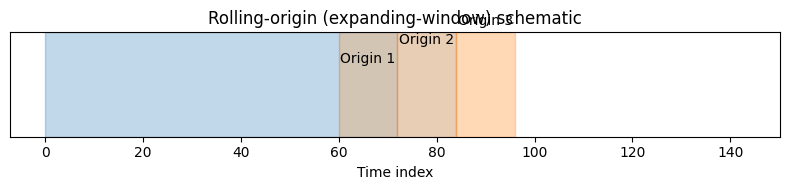

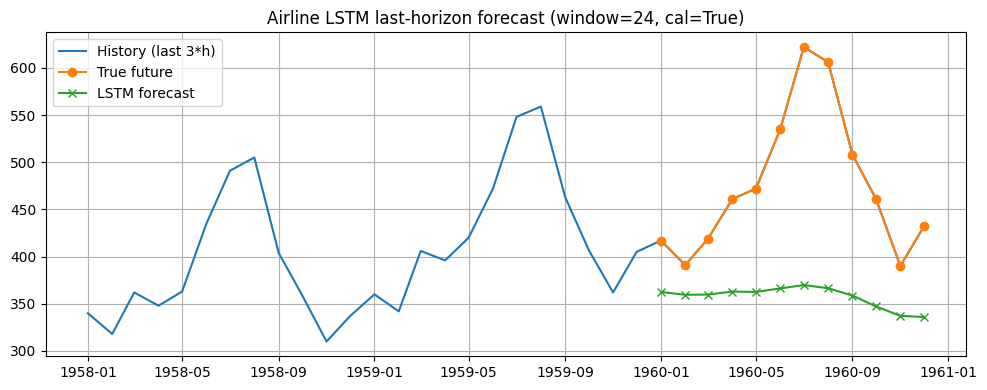

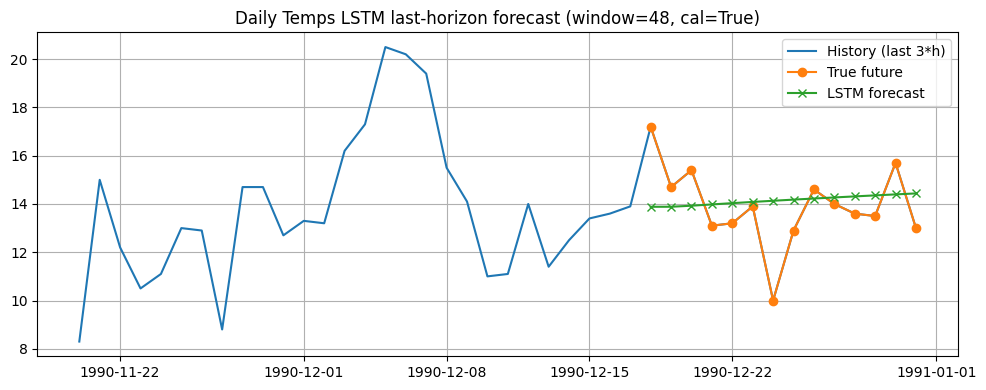

In [ ]:
# ============================================
# Cell 5: Run experiments + tables + 2 plots
# ============================================

def run_airline_experiment(
    y_series,
    window_lengths=[12, 24, 48],
    horizons=[1, 6, 12],
    use_calendar_list=[False, True],
    device=DEVICE,
):
    values = y_series.values.astype(np.float32)
    cal_all_full = build_month_onehot_features(y_series.index)
    seasonality_m = 12
    initial_train_size = 60   # first ~5 years
    origin_step = 1           # monthly origins

    all_results = []
    for use_cal in use_calendar_list:
        cal = cal_all_full if use_cal else None
        df = rolling_origin_backtest_lstm(
            values, cal,
            horizons=horizons,
            seasonality_m=seasonality_m,
            window_lengths=window_lengths,
            use_calendar=use_cal,
            initial_train_size=initial_train_size,
            origin_step=origin_step,
            hidden_size=32,
            num_layers=1,
            dropout=0.1,
            batch_size=32,
            max_epochs=50,
            lr=1e-3,
            val_ratio=0.2,
            patience=5,
            weight_decay=1e-4,
            device=device,
        )
        if not df.empty:
            df["dataset"] = "airline"
            df["model"] = "LSTM_cal" if use_cal else "LSTM"
            all_results.append(df)

    return pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()


def run_temps_experiment(
    y_series,
    window_lengths=[12, 24, 48],
    horizons=[1, 7, 14],
    use_calendar_list=[False, True],
    device=DEVICE,
):
    values = y_series.values.astype(np.float32)
    cal_all_full = build_dayofyear_sincos_features(y_series.index)
    seasonality_m = 365
    initial_train_size = 365   # first year
    origin_step = 7            # weekly origins to keep runtime reasonable

    all_results = []
    for use_cal in use_calendar_list:
        cal = cal_all_full if use_cal else None
        df = rolling_origin_backtest_lstm(
            values, cal,
            horizons=horizons,
            seasonality_m=seasonality_m,
            window_lengths=window_lengths,
            use_calendar=use_cal,
            initial_train_size=initial_train_size,
            origin_step=origin_step,
            hidden_size=32,
            num_layers=1,
            dropout=0.1,
            batch_size=64,
            max_epochs=30,   # fewer epochs for the longer daily series
            lr=1e-3,
            val_ratio=0.2,
            patience=5,
            weight_decay=1e-4,
            device=device,
        )
        if not df.empty:
            df["dataset"] = "temps"
            df["model"] = "LSTM_cal" if use_cal else "LSTM"
            all_results.append(df)

    return pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()


# -------- Plot helpers --------

def plot_rolling_origin_schematic(series_length, initial_train_size, horizon, origin_step=1, num_origins=3):
    """
    Simple schematic showing expanding-window origins and test blocks.
    """
    N = series_length
    origins = list(range(initial_train_size, N - horizon + 1, origin_step))[:num_origins]

    fig, ax = plt.subplots(figsize=(8, 2))
    x = np.arange(N)
    ax.plot(x, np.zeros_like(x), alpha=0)

    for i, origin in enumerate(origins):
        ax.axvspan(0, origin, alpha=0.1, color="tab:blue")
        ax.axvspan(origin, origin + horizon, alpha=0.3, color="tab:orange")
        ax.text(origin + horizon / 2, 0.02 * (i + 1),
                f"Origin {i+1}", ha="center", va="bottom")

    ax.set_yticks([])
    ax.set_xlabel("Time index")
    ax.set_title("Rolling-origin (expanding-window) schematic")
    plt.tight_layout()
    plt.show()


def plot_last_year_forecast(
    y_series,
    cal_all,
    seasonality_m,
    horizon,
    window,
    use_calendar,
    title_prefix="",
    device=DEVICE,
):
    """
    Fit LSTM on all data except last `horizon` points and forecast them.
    """
    values = y_series.values.astype(np.float32)
    N = len(values)
    train_end_idx = N - horizon

    preds = fit_and_forecast_lstm_one_origin(
        values, cal_all,
        train_end_idx=train_end_idx,
        window=window,
        max_h=horizon,
        use_calendar=use_calendar,
        hidden_size=32,
        num_layers=1,
        dropout=0.1,
        batch_size=32,
        max_epochs=50,
        lr=1e-3,
        val_ratio=0.2,
        patience=5,
        weight_decay=1e-4,
        device=device,
    )

    test = values[train_end_idx:]
    idx = y_series.index

    fig, ax = plt.subplots(figsize=(10, 4))
    hist_len = min(3 * horizon, N)
    ax.plot(idx[-hist_len:], values[-hist_len:], label="History (last 3*h)")
    ax.plot(idx[train_end_idx:], test, label="True future", marker="o")
    ax.plot(idx[train_end_idx:], preds, label="LSTM forecast", marker="x")

    ax.set_title(f"{title_prefix} LSTM last-horizon forecast (window={window}, cal={use_calendar})")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


# -------- Run everything --------

print("Running Airline LSTM experiment...")
airline_results = run_airline_experiment(y_air)
print("\nAirline LSTM results (metrics per horizon × window × calendar):")
display(airline_results.sort_values(["use_calendar", "window", "horizon"]).reset_index(drop=True))

print("\nRunning Daily Temps LSTM experiment...")
temps_results = run_temps_experiment(y_temp)
print("\nDaily Temps LSTM results (metrics per horizon × window × calendar):")
display(temps_results.sort_values(["use_calendar", "window", "horizon"]).reset_index(drop=True))

# Plot 1: rolling-origin schematic (use airline sizes as example)
plot_rolling_origin_schematic(
    series_length=len(y_air),
    initial_train_size=60,
    horizon=12,
    origin_step=12,
    num_origins=3,
)

# Plot 2a: last-year forecast overlay (airline)
cal_air = build_month_onehot_features(y_air.index)
plot_last_year_forecast(
    y_air,
    cal_air,
    seasonality_m=12,
    horizon=12,
    window=24,
    use_calendar=True,
    title_prefix="Airline",
)

# Plot 2b: last-year forecast overlay (temps)
cal_temp = build_dayofyear_sincos_features(y_temp.index)
plot_last_year_forecast(
    y_temp,
    cal_temp,
    seasonality_m=365,
    horizon=14,
    window=48,
    use_calendar=True,
    title_prefix="Daily Temps",
)
